In [1]:
import app.curve as curve
import app.calibration as c
import app.warp as w
import app.edges as e
import app.lane_finder as lf

import cv2
import matplotlib.pyplot as plt
import importlib
import numpy as np

from moviepy.editor import VideoFileClip
import matplotlib.image as mpimg
from IPython.display import HTML
%matplotlib inline

In [199]:
img = cv2.imread('test_images/test1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

calibrator = c.Camera_calibrator()
calibrator.initialize()
undist = calibrator.calibrate(img)
warped = w.warp(undist)
edges = e.Edges(warped)

_ = edges.gradient_color_channel(180,255,2,space=cv2.COLOR_RGB2HLS)
_ = edges.gradient_color_channel(1,255,0,space=cv2.COLOR_RGB2LUV)
_ = edges.gradient_color_channel(130,255,2,space=cv2.COLOR_RGB2LAB)



#gx = edges.gradient_x()

In [233]:
def generate_mask(warped):
    edges = e.Edges(warped)
    #_ = edges.gradient_color_channel(180,255,2,space=cv2.COLOR_RGB2HLS)
    #_ = edges.gradient_color_channel(225,255,0,space=cv2.COLOR_RGB2LUV)
    #_ = edges.gradient_color_channel(155,200,2,space=cv2.COLOR_RGB2LAB)
    
    #_ = edges.gradient_color_channel(200,255,2,space=cv2.COLOR_RGB2HLS)
    #_ = edges.gradient_color_channel(250,255,0,space=cv2.COLOR_RGB2LUV) # white
    _ = edges.gradient_color_channel(150,255,2,space=cv2.COLOR_RGB2LAB) # yellow
    _ = edges.gradient_x(15, 90)
    
    return edges.combined

def prepare_img(img):
    calibrator = c.Camera_calibrator()
    calibrator.initialize()
    undist = calibrator.calibrate(img)
    warped = w.warp(undist)
    return generate_mask(warped), warped

def get_base_points(img):
    histogram = np.sum(img[img.shape[0]/2:,:], axis=0)
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    return leftx_base, rightx_base, histogram

In [234]:
frame = 0
l_curve = None
r_curve = None
recheck_center = True

def handler():
    global frame
    global l_curve
    global r_curve
    global recheck_center
    
    frame = 0
    l_curve = None
    r_curve = None
    recheck_center = True

    def handle_frame(img):
        img = equalize_color_hist(img)
        img_y, img_x, _ = img.shape
        midpoint = int(img_x/2)
        x_offset=y_offset=10
        global frame
        global l_curve
        global r_curve
        global recheck_center
        
        frame += 1
        mask, warped = prepare_img(img)
        leftx_base = rightx_base = 0
        if recheck_center is True:
            leftx_base, rightx_base, _ = get_base_points(mask)
            if l_curve is not None:
                l_curve.center= leftx_base
            if r_curve is not None:
                r_curve.center = rightx_base
            recheck_center = False
    
        if l_curve is None or r_curve is None:
            l_curve = curve.Curve(leftx_base, (0, midpoint), margin=100)
            r_curve = curve.Curve(rightx_base, (midpoint, img_x), margin=100)
        
        l_valid = l_curve.curve_fit(mask)
        r_valid = r_curve.curve_fit(mask)
    
        if l_valid is False or r_valid is False:
            recheck_center = True
    
        marked = np.zeros_like(warped)
        #l_curve.draw_curve(marked, thick=10)
        #r_curve.draw_curve(marked, thick=10)
        
        marked = lf.plot_lanes(img, l_curve.fit, r_curve.fit, warped.shape, fill=True)
    
        unwarped = w.unwarp(marked)
        final = cv2.addWeighted(img,0.7,unwarped,0.99,0)
        
        s_img = mask*255
        s_img = cv2.cvtColor(s_img, cv2.COLOR_GRAY2RGB)
        l_curve.curve_windows.draw_rect(s_img)
        r_curve.curve_windows.draw_rect(s_img)
        l_curve.draw_curve(s_img, thick=4)
        r_curve.draw_curve(s_img, thick=4)

        s_img_x, s_img_y = int((s_img.shape[1]/1.5)), int((s_img.shape[0]/1.5))
        s_img = cv2.resize(s_img, (s_img_y, s_img_y))
        final[y_offset:y_offset+s_img.shape[0], x_offset:x_offset+s_img.shape[1]] = s_img
      
    
        #if frame % 10 == 0:
        #    recheck_center = True
        
        return final
    return handle_frame


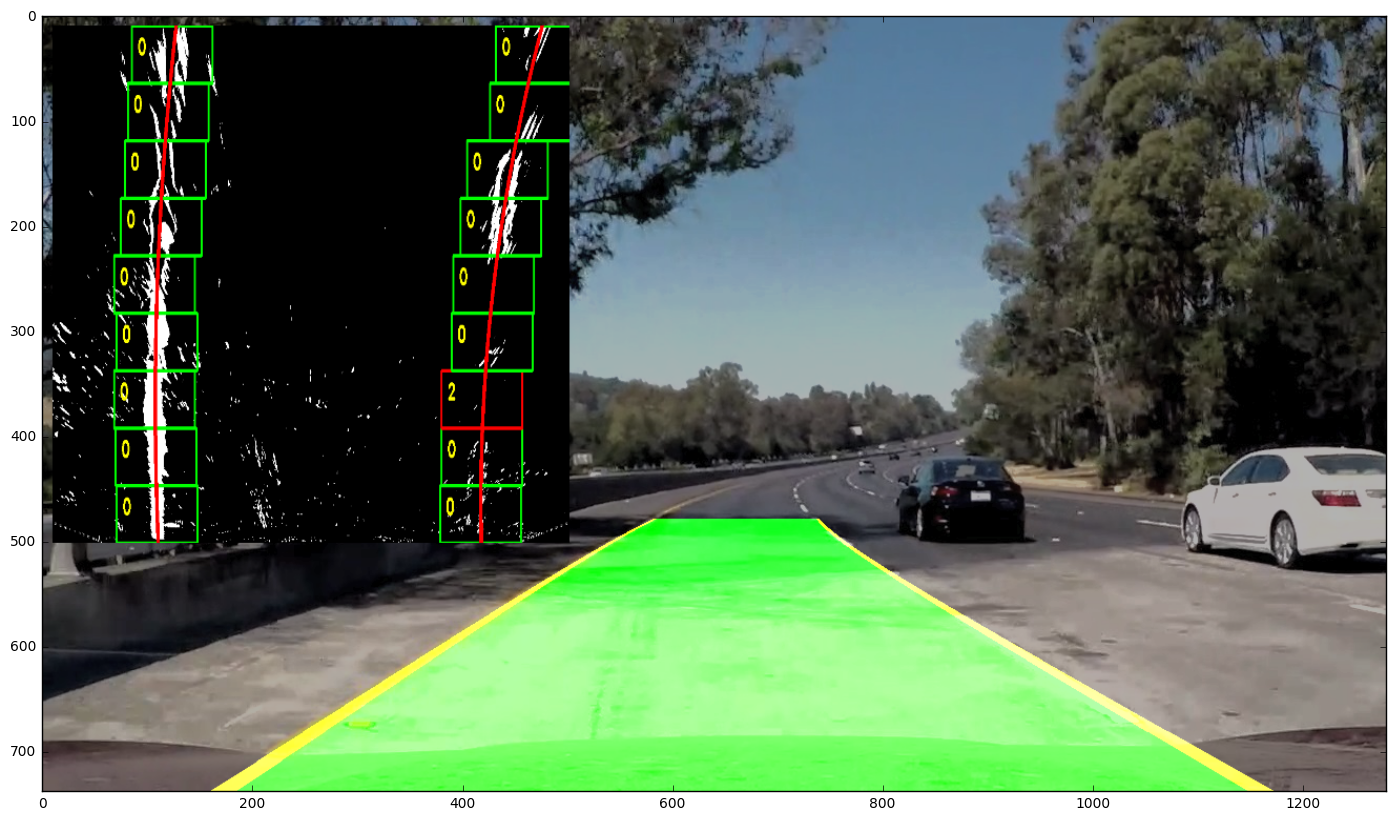

In [238]:
importlib.reload(curve)
img = cv2.imread('failed/image138.jpg')
img = cv2.imread('extra/test3.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

processor = handler()
fr = processor(img)
plt.figure(figsize=(20,10))
plt.imshow(fr)

In [36]:
importlib.reload(curve)

<module 'app.curve' from '/home/tadas/shared/udacity/CarND-Advanced-Lane-Lines/app/curve.py'>

In [17]:
str(2)

'2'

In [34]:
def equalize_color_hist(img):
    ycrcb = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    ycrcb[:,:,0] = cv2.equalizeHist(ycrcb[:,:,0])
    result = cv2.cvtColor(ycrcb, cv2.COLOR_YCrCb2RGB)
    return result

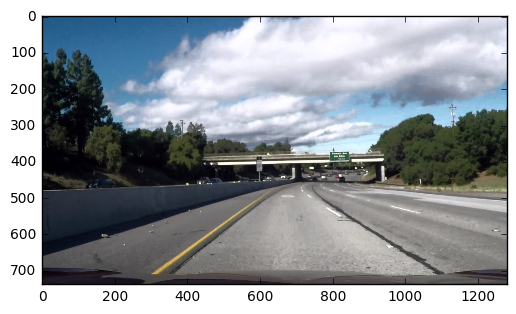

In [35]:
res = equalize_color_hist(img)
plt.imshow(res)

In [239]:
processor = handler()
white_output = 'challenge_video_out1.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(processor)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video challenge_video_out1.mp4
[MoviePy] Writing video challenge_video_out1.mp4


100%|██████████| 485/485 [05:51<00:00,  1.53it/s]     | 1/485 [00:00<05:48,  1.39it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_out1.mp4 

CPU times: user 8min 20s, sys: 1.46 s, total: 8min 21s
Wall time: 5min 51s
